In [1]:
from tensorflow import keras
import tensorflow.keras.layers as layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

## Constants and Functions

In [3]:
SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=((6, 6)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('img/' + title + '.png')

## Custom Callbacks

In [3]:
import notifiers
import time
import datetime

class Notifier(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super(Notifier, self).__init__()
        self.model_name = model_name
        self.token = 'av4arh4gjmz9x1i2t3oqanyfjxbchc'
        self.user = 'ua2ym7pyg7mjg71gzrdzusrd6hr7bu'
        self.pushover = notifiers.get_notifier('pushover')
        self.message = "{} training completed in {} \nVal Loss: {} | Val Accuracy: {}"
        print('model name: {}'.format(self.model_name))
        
    def on_train_begin(self, logs=None):
        self.start = time.time()

    def on_train_end(self, logs=None):
        self.end = time.time()
        runtime = datetime.timedelta(seconds=self.end - self.start)
        
        if logs:
            msg = self.message.format(self.model_name, runtime,
                                      round(logs['val_loss'], 3),
                                      round(logs['val_accuracy']*100, 3))
        else:
            msg = "{} training completed in {} \nLogs not found".format(self.model_name, runtime)
        print(msg)
        self.pushover.notify(message=msg, token=self.token, user=self.user)
        

## Acquire Data (+ Preprocess)

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

labels = list(test_ds.class_indices.keys())
labels

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.


['dyskeratotic',
 'koilocytotic',
 'metaplastic',
 'parabasal',
 'superficialIntermediate']

## Preprocess Data

28.0 150.0


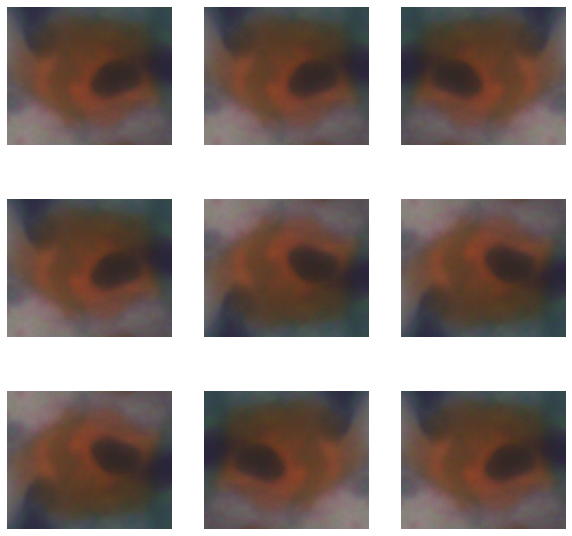

In [6]:
import tensorflow.keras.layers as layers

# -- PREPROCESSING SEQUENCE -- #
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
data_augmentation = layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')

image_path = 'img/005_01.bmp'
image = tf.keras.preprocessing.image.load_img(image_path)
image_arr = keras.preprocessing.image.img_to_array(image)

image_arr = tf.expand_dims(image_arr, 0)

maxValue = np.amax(image_arr)
minValue = np.amin(image_arr)
print(minValue, maxValue)

preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
#     layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = preprocess(image_arr)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Model Architecture and HP Tuning

Model: "CervixNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 8, 8, 2048)   20861480    image[0][0]                      
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 8, 8, 2048)   23564800    image[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 4096)   0           xception[0][0]                   
                                                                 resnet50v2[0][0]         

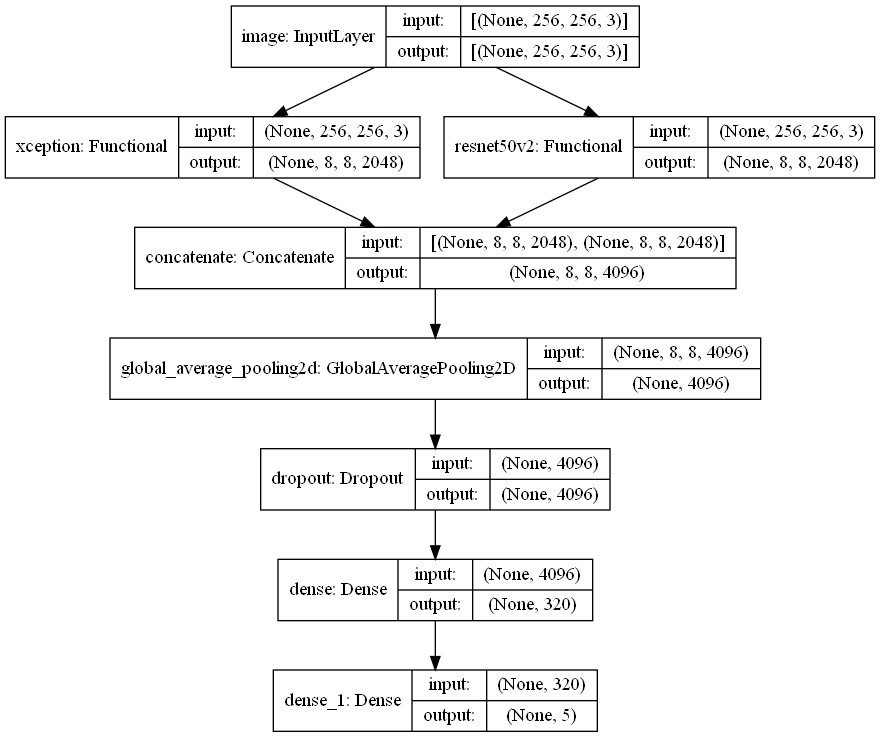

In [5]:
from tensorflow.keras.applications import ResNet50V2, Xception

# -- CONVOLUTIONAL BASE -- #
xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
for layer in xception_base.layers[:(len(xception_base.layers) - 16)]:
    layer.trainable = False
# xception_base.summary()
# xception_base.trainable = False

resnet50_base_partial_frozen = ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
for layer in resnet50_base_partial_frozen.layers[:(len(resnet50_base_partial_frozen.layers) - 36)]:
    layer.trainable = False
# resnet50_base_partial_frozen.trainable = False

inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='image')
xception_features = xception_base(inputs)
resnet50_features = resnet50_base_partial_frozen(inputs)
concat_features = layers.concatenate([xception_features, resnet50_features])
x = layers.GlobalAveragePooling2D()(concat_features)
x = layers.Dropout(.2, seed=SEED)(x)
x = layers.Dense(320, activation='relu')(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

concat_model = keras.Model(inputs=inputs, outputs=out, name='CervixNet')
concat_model.summary()
keras.utils.plot_model(concat_model, to_file="img/concat_arch.png", show_shapes=True)

In [9]:
from tensorflow.keras import Sequential
from kerastuner import HyperModel, HyperParameters, RandomSearch

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units = hp.Int('fc_units', min_value=32, max_value=512,
                          step=32, default=128)
        fc_activation = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4,
                               step=0.1, default=0.3)
        
        inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='image')
        xception_features = xception_base(inputs)
        resnet50_features = resnet50_base_partial_frozen(inputs)
        concat_features = layers.concatenate([xception_features, resnet50_features])
        x = layers.GlobalAveragePooling2D()(concat_features)
        x = layers.Dropout(dropout_rate, seed=SEED)(x)
        x = layers.Dense(fc_units, activation=fc_activation)(x)
        out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

        concat_model = keras.Model(inputs=inputs, outputs=out, name='CervixNet')
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        concat_model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return concat_model
    
hypermodel = HyperCervixNet()

ModuleNotFoundError: No module named 'kerastuner'

In [11]:
import datetime
import time
import json

# -- TUNER -- #
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 1
SEARCH_EPOCHS = 50

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='concat',
)
tuner.search_space_summary()

tuning_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        mode='min', baseline=None, restore_best_weights=True),
    Notifier('Concat HPS'),
]

start = time.time()
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds, callbacks=tuning_callbacks)
end = time.time() - start
print('Concat hyperparameter search time: {}'.format(datetime.timedelta(seconds=end)))

# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('hp/concat_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('models/hp_search/concat_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))

NameError: name 'RandomSearch' is not defined

## Refitting the Model

model name: Concat Refit
Epoch 1/200
102/102 - 121s - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.4018 - val_accuracy: 0.9586
Epoch 2/200
102/102 - 112s - loss: 0.0349 - accuracy: 0.9929 - val_loss: 0.3110 - val_accuracy: 0.9371
Epoch 3/200
102/102 - 112s - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.3040 - val_accuracy: 0.9520
Epoch 4/200
102/102 - 112s - loss: 0.0070 - accuracy: 0.9966 - val_loss: 0.3240 - val_accuracy: 0.9636
Epoch 5/200
102/102 - 112s - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.2859 - val_accuracy: 0.9570
Epoch 6/200
102/102 - 112s - loss: 0.0192 - accuracy: 0.9966 - val_loss: 0.5329 - val_accuracy: 0.9305
Epoch 7/200
102/102 - 112s - loss: 0.0226 - accuracy: 0.9944 - val_loss: 0.3961 - val_accuracy: 0.9404
Epoch 8/200
102/102 - 112s - loss: 0.0306 - accuracy: 0.9941 - val_loss: 0.2227 - val_accuracy: 0.9553
Epoch 9/200
102/102 - 112s - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.2821 - val_accuracy: 0.9553
Epoch 10/200
102/102 - 112s - loss: 0.0092 - acc

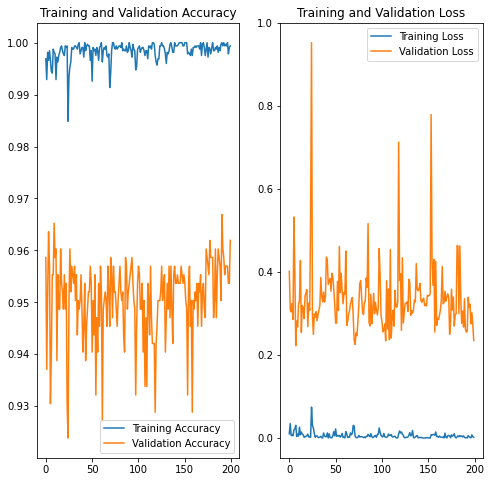

In [8]:
fit_callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', min_delta=1e-4, patience=10,
#         mode='min', baseline=None, restore_best_weights=True),
    Notifier('Concat Refit'),
    tf.keras.callbacks.CSVLogger('logs/concat_refit.log')
]

start = time.time()
history = best_model.fit(train_ds, epochs=200, validation_data=val_ds, verbose=2, callbacks=fit_callbacks)
end = time.time() - start
print('Concat refit time: {}'.format(datetime.timedelta(seconds=end)))
n_epochs_best = len(history.history['val_loss'])

filename = 'concat_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Evaluating the Model

Confusion matrix, without normalization
[[40  1  1  0  0]
 [ 0 40  0  2  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 43]]


0.9759615384615384

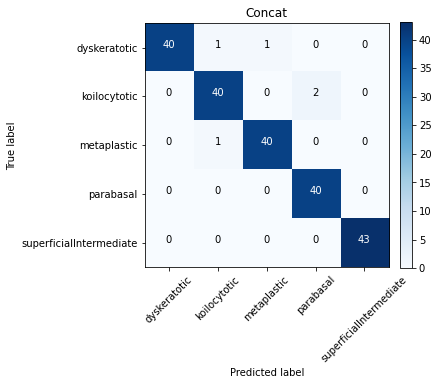

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

y_true = test_ds.classes

model = keras.models.load_model('models/concat_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="Concat")

accuracy_score(y_true, rounded_pred)

## Arch-tuning

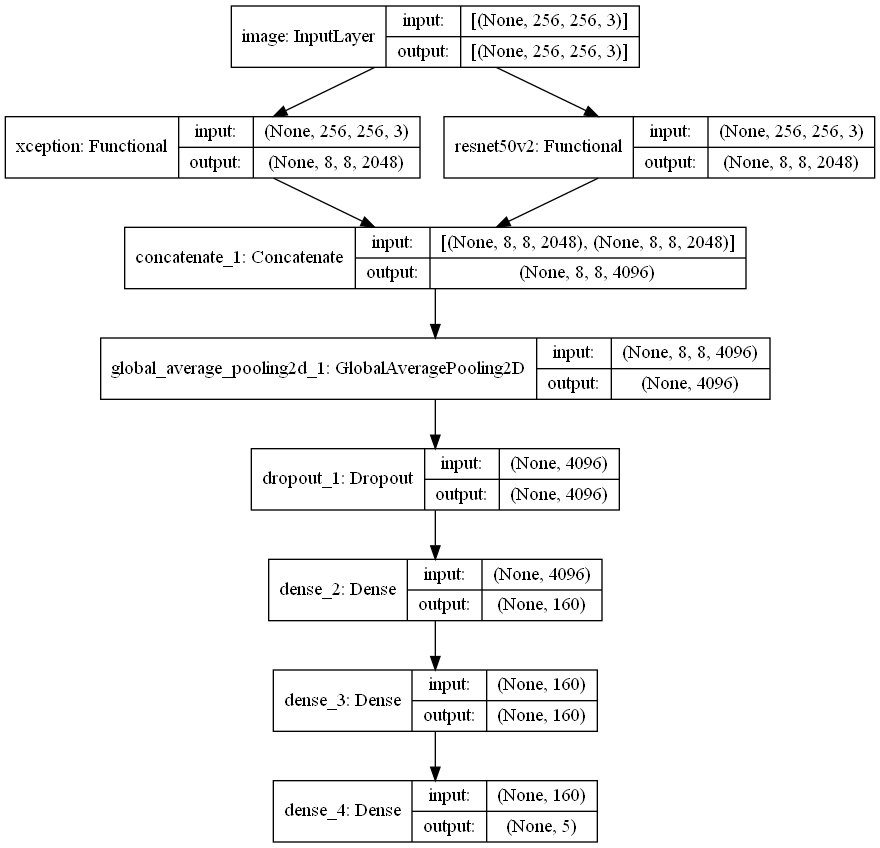

In [6]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='image')
xception_features = xception_base(inputs)
resnet50_features = resnet50_base_partial_frozen(inputs)
concat_features = layers.concatenate([xception_features, resnet50_features])
x = layers.GlobalAveragePooling2D()(concat_features)
x = layers.Dropout(0.4, seed=SEED)(x)
x = layers.Dense(160, activation='tanh', kernel_regularizer='l2')(x)
x = layers.Dense(160, activation='tanh', kernel_regularizer='l2')(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

concat_model = keras.Model(inputs=inputs, outputs=out, name='CervixNet')

# decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# compile the model
concat_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

keras.utils.plot_model(concat_model, to_file="img/concat_reg_arch.png", show_shapes=True)

model name: Concat Regularized
Epoch 1/200
50/50 - 70s - loss: 3.7851 - accuracy: 0.8290 - val_loss: 4.1665 - val_accuracy: 0.5497
Epoch 2/200
50/50 - 61s - loss: 1.9324 - accuracy: 0.8760 - val_loss: 1.6353 - val_accuracy: 0.8841
Epoch 3/200
50/50 - 61s - loss: 1.2249 - accuracy: 0.9002 - val_loss: 1.2179 - val_accuracy: 0.8543
Epoch 4/200
50/50 - 62s - loss: 0.8346 - accuracy: 0.9162 - val_loss: 0.7454 - val_accuracy: 0.9073
Epoch 5/200
50/50 - 62s - loss: 0.5661 - accuracy: 0.9331 - val_loss: 0.6536 - val_accuracy: 0.8841
Epoch 6/200
50/50 - 62s - loss: 0.4523 - accuracy: 0.9319 - val_loss: 0.4412 - val_accuracy: 0.9205
Epoch 7/200
50/50 - 62s - loss: 0.3191 - accuracy: 0.9531 - val_loss: 0.3941 - val_accuracy: 0.9156
Epoch 8/200
50/50 - 61s - loss: 0.3375 - accuracy: 0.9326 - val_loss: 0.6210 - val_accuracy: 0.8659
Epoch 9/200
50/50 - 62s - loss: 0.3068 - accuracy: 0.9450 - val_loss: 0.5054 - val_accuracy: 0.9073
Epoch 10/200
50/50 - 61s - loss: 0.2896 - accuracy: 0.9441 - val_loss

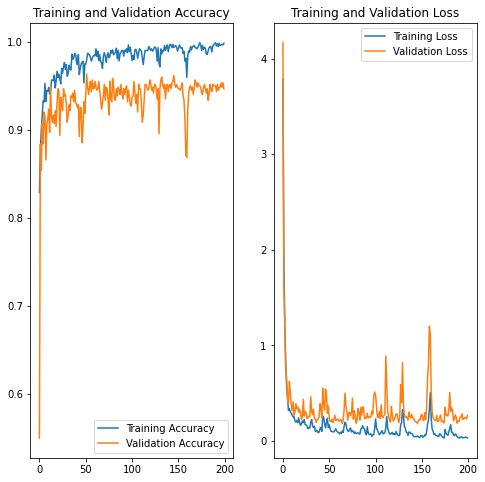

In [7]:
fit_callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', min_delta=1e-4, patience=10,
#         mode='min', baseline=None, restore_best_weights=True),
    Notifier('Concat Regularized'),
    tf.keras.callbacks.CSVLogger('logs/concat_reg_fit.log')
]

start = time.time()
history = concat_model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=fit_callbacks, verbose=2, steps_per_epoch=50)
end = time.time() - start
print('Concat fit time: {}'.format(datetime.timedelta(seconds=end)))
n_epochs_best = len(history.history['val_loss'])

filename = 'concat_reg_fit_e{}'.format(n_epochs_best)
concat_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

In [29]:
concat_model.summary()

Model: "CervixNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 8, 8, 2048)   20861480    image[0][0]                      
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 8, 8, 2048)   23564800    image[0][0]                      
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 8, 8, 4096)   0           xception[4][0]                   
                                                                 resnet50v2[4][0]         

Confusion matrix, without normalization
[[40  1  1  0  0]
 [ 0 40  0  2  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 43]]


0.9759615384615384

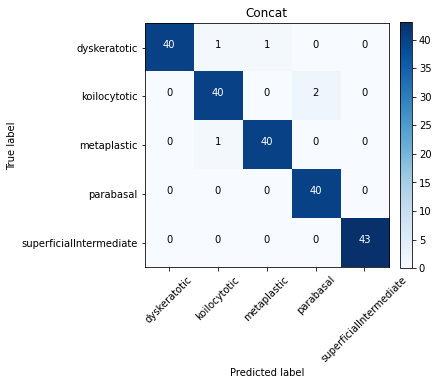

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

y_true = test_ds.classes

model = keras.models.load_model('models/concat_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="Concat")

accuracy_score(y_true, rounded_pred)

## Extracting Misclassified Images

### ConcatV1

In [16]:
model = keras.models.load_model('models/concat_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)
print(rounded_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[ 19  41  43  75 108]
076_02
dataset\test\dyskeratotic\076_02.bmp
True: dyskeratotic, predicted: metaplastic


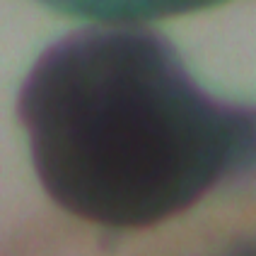

221_05
dataset\test\dyskeratotic\221_05.bmp
True: dyskeratotic, predicted: koilocytotic


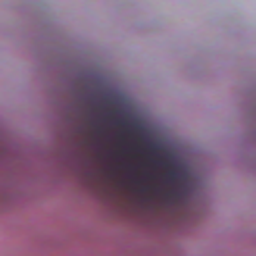

015_08
dataset\test\koilocytotic\015_08.bmp
True: koilocytotic, predicted: parabasal


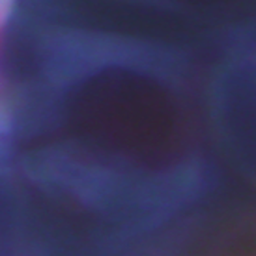

147_03
dataset\test\koilocytotic\147_03.bmp
True: koilocytotic, predicted: parabasal


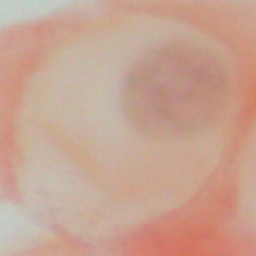

164_04
dataset\test\metaplastic\164_04.bmp
True: metaplastic, predicted: koilocytotic


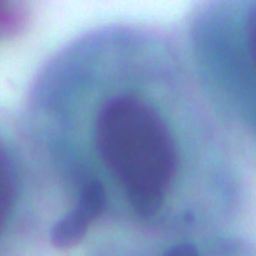

In [17]:
from PIL import Image
from shutil import copyfile

y_true = test_ds.classes
incorrects = np.nonzero(rounded_pred.reshape((-1,)) != y_true)
print(incorrects[0])

n_test = len(test_ds)
filenames = []

for root, dirs, files in os.walk("dataset\\test"):
    for file in files:
        filenames.append(os.path.join(root, file))

for i in incorrects[0]:
    path_to_file = filenames[i]
    filename = path_to_file.split("\\")[-1].split(".")[0]
    print(filename)

    img = Image.open(path_to_file)
    true_label = labels[y_true[i]]
    pred_label = labels[rounded_pred[i]]
    img = img.resize((256, 256))
    img.save("img\\misclassified\\concat\\{}_{}{}.png".format(true_label[:3], pred_label[:3], filename))
    print(path_to_file)
    print("True: {}, predicted: {}".format(true_label, pred_label))
    display(img)

### ConcatV2

In [7]:
model = keras.models.load_model('models/concat_reg_fit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)
print(rounded_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[ 52 108 165]
dataset\test\koilocytotic\064_02.bmp
True: koilocytotic, predicted: dyskeratotic


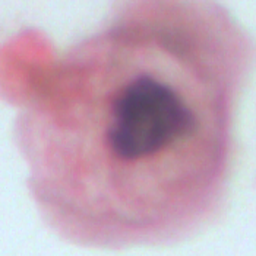

dataset\test\metaplastic\164_04.bmp
True: metaplastic, predicted: koilocytotic


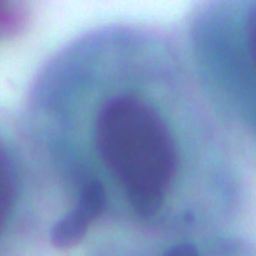

dataset\test\superficialIntermediate\005_04.bmp
True: superficialIntermediate, predicted: dyskeratotic


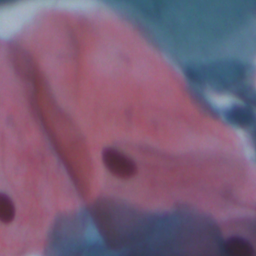

In [8]:
from PIL import Image
from shutil import copyfile

y_true = test_ds.classes
incorrects = np.nonzero(rounded_pred.reshape((-1,)) != y_true)
print(incorrects[0])

n_test = len(test_ds)
filenames = []

for root, dirs, files in os.walk("dataset\\test"):
    for file in files:
        filenames.append(os.path.join(root, file))

for i in incorrects[0]:
    path_to_file = filenames[i]

    img = Image.open(path_to_file)
    true_label = labels[y_true[i]]
    pred_label = labels[rounded_pred[i]]
    img = img.resize((256, 256))
    img.save("img\\misclassified\\concatv2\\{}_{}.png".format(true_label[:3], pred_label[:3]))
    print(path_to_file)
    print("True: {}, predicted: {}".format(true_label, pred_label))
    display(img)